In [34]:
import cv2
import matplotlib.pyplot as plt

### 이미지 리사이즈 (원본 비율 유지)

- 이미지 리사이즈 공통 함수

In [35]:
def resize_image(img) :
    # 원본 이미지 크기
    origin_size = img.shape[:2]

    # 조정할 이미지 사이즈
    resize = 224

    # 이미지의 높이(h)와 너비(w) 중 가장 긴 변을 기준으로 비율 조정
    # 예를 들어, 원본 이미지 크기가 2268(w)x4032(h) 라면 가장 긴 변인 4032 를 기준으로 224로 맞추기 위한 비율 계산
    # 계산된 비율로 이미지의 모든 변을 조정
    ratio = float(resize) / max(origin_size)
    new_size = tuple([int(x * ratio) for x in origin_size])

    # 리사이즈
    resized_image = cv2.resize(img, (new_size[1], new_size[0]))

    # 패딩 추가
    # 리사이즈 된 이미지가 224x224 크기에 맞지 않을 수 있으므로 패딩 계산 필요
    # 예를 들어, 새로운 이미지 크기가 126(w)x224(h) 라면 너비가 부족하므로 좌우에 49픽셀씩 패딩 추가
    delta_w = resize - new_size[1]
    delta_h = resize - new_size[0]

    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    new_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return new_image

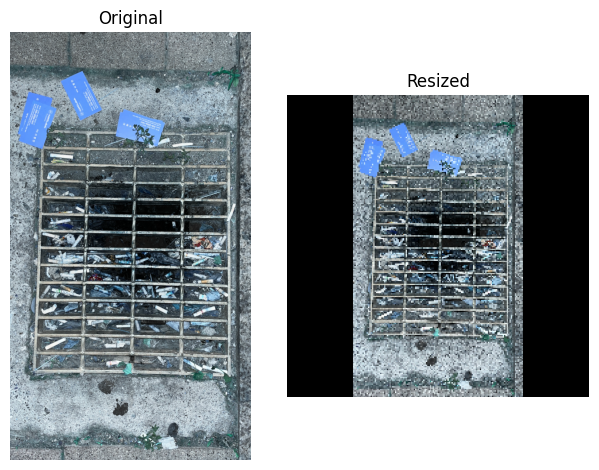

In [ ]:
# 이미지 리사이즈
image = cv2.imread('heavy/IMG_9514.JPG')
new_image = resize_image(image)

# 원본
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original')
plt.axis('off')

# 출력
plt.subplot(1, 2, 2)
plt.imshow(new_image)
plt.title('Resized')
plt.axis('off')

plt.tight_layout()
plt.show()

### 이미지 윤곽선 검출

In [48]:
# img = cv2.imread('clean/IMG_9380.JPG')
# img = cv2.imread('heavy/IMG_9514.JPG')
img = cv2.imread('heavy_aug/IMG_9548_aug2.jpg')
# img = cv2.imread('medium/IMG_4677.jpg')
new_img = resize_image(img)

# 이미지 채널 변경
gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
# cv2.imshow('gray', gray)

# 이미지 이진화 수행
# 최대 임계값 : 255
# 임계 처리 : 가우시안 필터 사용 (블러 처리도 함께 적용됨)
# 임계치 처리 적용 영역 크기 : 9
# 평균이나 가중 평균에서 차감할 값 : 5
# dst = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 5)
# cv2.imshow('dst', dst)

# 이미지 블러 처리
# 노이즈를 줄이기 위함
gray = cv2.GaussianBlur(gray, (7, 7), 0)
# cv2.imshow('blured', gray)

# 이미지 경계선(픽셀의 값이 갑자기 커지거나 작아지는 부분) 검출
edged = cv2.Canny(gray, 100, 200)
# cv2.imshow('canny', edged)

# 탐지한 경계선 두껍게 만들기
edged = cv2.dilate(edged, None, iterations=1)
# cv2.imshow('dilated', edged)

# 탐지한 경계선 얇게 만들기
edged = cv2.erode(edged, None, iterations=1)
# cv2.imshow('eroded', edged)

# 이미지 윤곽선 검출 (검출한 윤곽선 좌표, 계층 정보 리턴)
# cv2.RETR_EXTERNAL : 가장 바깥쪽 라인 검출
# cv2.CHAIN_APPROX_SIMPLE : 끝 점만 남기고 다른 점(수평, 수직, 대각선 방향)들은 모두 제거
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 가장 큰 윤곽선
largest_contour = max(contours, key=cv2.contourArea)
# 가장 큰 윤곽선 넓이 (단위 : 픽셀)
largest_area = cv2.contourArea(largest_contour)
print(largest_area)

# 결과 이미지
result_img = new_img.copy()
for i, contour in enumerate(contours) :
    mmt = cv2.moments(contour)
    # 윤곽선 중심점 계산
    cx = int(mmt['m10'] / mmt['m00'])
    cy = int(mmt['m01'] / mmt['m00'])
    # print(cx, cy)

    # 영역 넓이 (단위 : 픽셀)
    area = mmt['m00']
    # 영역 외곽선 길이
    length = cv2.arcLength(contour, True)

    # 윤곽선 표시 - 노란색
    cv2.drawContours(result_img, [contour], -1, (0, 255, 255), 2)
    
    # 윤곽선 중심점 표시 - 파란색
    cv2.circle(result_img, (cx, cy), 3, (255, 0, 0), -1)

    # 영역 넓이 표시
    cv2.putText(result_img, f'A : {area:.0f}', (cx, cy+20), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)

    # 영역 외곽선 길이 표시
    cv2.putText(result_img, f'L : {length:.2f}', tuple(contour[0][0]), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)

    # 가장 큰 윤곽선 정보만 표시
    # if largest_area == area : 
    #     cv2.drawContours(result_img, [contour], -1, (0, 255, 255), 2)
        
    #     # 컨투어 중심점 표시
    #     cv2.circle(result_img, (cx, cy), 3, (255, 0, 0), -1)

    #     # 영역 넓이 표시
    #     cv2.putText(result_img, f'A : {area:.0f}', (cx, cy+20), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)

    #     # 영역 외곽선 길이 표시
    #     cv2.putText(result_img, f'L : {length:.2f}', tuple(contour[0][0]), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)

    # 각 윤곽선별 넓이 계산
    print(f'area : {cv2.contourArea(contour, False):.2f}')

# 실제 면적 계산
# 픽셀 당 몇 cm 인지 안다는 가정이 필요
pixel_ratio = 50
largest_area_cm = largest_area / (pixel_ratio ** 2)
print(f'가장 큰 영역의 실제 면적 (추정) : {largest_area_cm:.2f} ㎠')

cv2.imshow('contours', result_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

22580.0
area : 2.00
area : 75.50
area : 13.50
area : 19.00
area : 22580.00
area : 8.50
area : 784.00
area : 1323.50
가장 큰 영역의 실제 면적 (추정) : 9.03 ㎠


### ROI(Region Of Interest) 설정

In [ ]:
# img = cv2.imread('medium/IMG_4677.jpg')
img = cv2.imread('heavy/IMG_9514.JPG')
new_img = resize_image(img)

is_dragged = False
# ix, iy = -1, -1
blue, yellow = (255, 0, 0), (0, 255, 255)

# 마우스 클릭하고 뗄 때, 이미지 위에 직사각형 그리는 함수
def onMouse(event, x, y, flags, param) :
    global is_dragged, ix, iy, blue, yellow

    # 마우스를 눌렀을 때, 초기 위치 저장
    if event == cv2.EVENT_LBUTTONDOWN :
        is_dragged = True
        ix, iy = x, y
    # 마우스를 드래그 할 때, 파란색 직사각형 그리기
    elif event == cv2.EVENT_MOUSEMOVE :
        img_draw = param.copy()
        cv2.rectangle(img_draw, (ix, iy), (x, y), blue, 2)
        cv2.imshow('Show Image', img_draw)
    # 마우스를 뗐을 때, 이미지 위에 노란란 직사각형 그리기
    # ix, iy : 마우스 처음 클릭한 위치
    # x, y : 마우스 뗐을때의 그 위치
    # w, h : 직사각형 너비, 높이
    elif event == cv2.EVENT_LBUTTONUP :
        if is_dragged :
            is_dragged = False
            w = x - ix
            h = y - iy

            # 드래그한 직시각형 영역이 있을 때, 관심영역 찾기
            if w > 0 and h > 0 :
                cv2.rectangle(param, (ix, iy), (x, y), yellow, 2)
                cv2.imshow('Show Image', param)

                # 이미지에서 관심영역만 분리하여 새 창에 노출
                roi = param[iy:iy+h, ix:ix+w]
                cv2.imshow('ROI', roi)
                cv2.moveWindow('ROI', 500, 250)
                cv2.imwrite('ROI.jpg', roi)

cv2.imshow('Show Image', new_img)
cv2.setMouseCallback('Show Image', onMouse, param=new_img)
cv2.waitKey(0)
cv2.destroyAllWindows()